In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import numpy as np

from prettytable import PrettyTable

In [2]:
class Element:   #Define a class for each of the elements from each line of the BEATCH file 

    def __init__(self, line, offsetX = 0, offsetY=0, offsetZ=0): #Initialise the class
        self.ProcessRawLine(line, offsetX, offsetY, offsetZ)
        
    def ProcessRawLine(self, line, offsetX, offsetY, offsetZ): #Reads the line and takes the relevant part of the string into the rigt variable. Cast to right type as well
        
        self.elemNumber = int( line[0:4] )
        self.elemName   = str( line[5:15] )
        self.elemComment= str( line[16:36] )
        self.elemID     = int( line[36:38] )
        self.elemLength = float( line[38:46] )
        self.elemX      = float( line[62:73] ) + offsetX
        self.elemY      = float( line[73:84] ) + offsetY
        self.elemZ      = float( line[84:95] ) + offsetZ
        self.elemHAngle = float( line[94:104] )
        self.elemVAngle = float( line[104:114] )
        self.elemS      = float( line[114:123] )
        
        
def ReadBeatchOut(file, offsetX = 0, offsetY=0, offsetZ=0): #Read a beatch file. Input is filename. Offsets are arbitrary displacements one can add to facilitate plotting
                                                            #Returns a list of "element" objects containing all the useful info.
        
    #Line in BEATCH output before the useful data is. Use this to tell when the interesting data starts.
    
    headerLine = '                                             M  RAD     DEG       M           M           M               RAD           M\n'

    fileElements = []
    with open(file) as f:
        StartRead = False #Flag set to True when we reach headerLine. Tells when we are at the useful lines in the file
        
        for line in f:

            if StartRead: #When we reach the flag start to create objects and add to the list of elements
                fileElements.append(Element(line, offsetX, offsetY, offsetZ))
                continue

            if line == headerLine:
                StartRead = True
                next(f) #There is a blank line between header and data. Skips it
    return(fileElements)


def Rotate(x, y, theta): #angle in radians. A simple rotation  for plotting
    
    x_new = x * np.cos(theta) - y * np.sin(theta)
    y_new = x * np.sin(theta) + y * np.cos(theta)
    return(x_new, y_new)

In [3]:
def PlotLine(elements, RotAngle = 0, degrees = True): #Feed into this the list of objects. Returns ax object for the plot

    if degrees: #If the rotation is given in degrees convert to rads
        RotAngle = RotAngle * np.pi/180
    
    fig, ax = plt.subplots()
    sizeRect = 1 #Arbitrary parameter on the size (direction perpendicular to beam) of the elements. This is not in BEATCH, so placed here arbitrarily

    allx = [] #Store all x values of elements
    ally = [] #Store all y values of elements

    for item in elements: #Plot element by element
        
        if item.elemID == 1: continue #Dont need to plot drifts

        x = item.elemX #x defined at the end of the element
        y = item.elemY #y defined at the end of the element
        z = item.elemZ #z defined at the end of the element
        #s = item.elemComment
        
        if RotAngle != 0: #If we want to rotate, rotate the coordinates of the element
            x, y = Rotate(x, y, RotAngle)
        
        XYAngle = item.elemHAngle*180/np.pi + RotAngle * 180/np.pi #Angle of the element according to BEATCH, with the inclusion of the rotation angle. Plotting done in degrees, so convert
        
        length = item.elemLength
        color = PicKColor(item.elemID)


        #The plotting of rectangles is done from bottom left corner. To keep angle consistent, we split the plotting of elements in 2 parts, a top and bottom, such that the corner is 
        #along the beam path. - length plots backwards from the end. Place at (0,0) so angle is consistent
        rectXYPlaneTop  = Rectangle((0,0), -length, sizeRect/2, angle=XYAngle, color=color, alpha=0.4) 
        rectXYPlaneBott = Rectangle((0,0), -length, -sizeRect/2, angle=XYAngle, color=color, alpha=0.4)
        
        #Move magnets to correct locations
        rectXYPlaneTop.set_xy((x, y))
        rectXYPlaneBott.set_xy((x, y))
        
        #Plot magnets
        ax.add_patch(rectXYPlaneTop)
        ax.add_patch(rectXYPlaneBott)
        
        #Add text
        #ax.text(x-length/2, y - txtOffset, s)

        #Add to list of x,y for setting limits of plot
        allx.append(x)
        ally.append(y)


    ax.grid()
    ax.set_xlim(min(allx), max(allx))
    ax.set_ylim(min(ally), max(ally))
    
    return(ax)



def PicKColor(elemNumber):
    
    if elemNumber == 8 :
        color = 'green'
    elif elemNumber == 2 or elemNumber == 3 :
        color = 'blue'
    elif elemNumber == 20 :
        color = 'goldenrod'
    elif elemNumber == 10 :
        color = 'black'        
    elif elemNumber == 6 or elemNumber == 7 or elemNumber == 9 or elemNumber == 22  or elemNumber == 14:
        color = 'pink'
    else:
        color = 'red'
    return(color)

In [40]:
def InsertElementInPlot(item, ax, RotAngle = 0, degrees = True): #Feed into this the list of objects. Returns ax object for the plot

    if degrees: #If the rotation is given in degrees convert to rads
        RotAngle = RotAngle * np.pi/180
    
    sizeRect = 1 #Arbitrary parameter on the size (direction perpendicular to beam) of the elements. This is not in BEATCH, so placed here arbitrarily


    x = item.elemX #x defined at the end of the element
    y = item.elemY #y defined at the end of the element
    z = item.elemZ #z defined at the end of the element
    #s = item.elemComment

    if RotAngle != 0: #If we want to rotate, rotate the coordinates of the element
        x, y = Rotate(x, y, RotAngle)

    XYAngle = item.elemHAngle*180/np.pi + RotAngle * 180/np.pi #Angle of the element according to BEATCH, with the inclusion of the rotation angle. Plotting done in degrees, so convert

    length = item.elemLength
    color = PicKColor(item.elemID)


    #The plotting of rectangles is done from bottom left corner. To keep angle consistent, we split the plotting of elements in 2 parts, a top and bottom, such that the corner is 
    #along the beam path. - length plots backwards from the end. Place at (0,0) so angle is consistent
    rectXYPlaneTop  = Rectangle((0,0), -length, sizeRect/2, angle=XYAngle, color=color, alpha=0.4) 
    rectXYPlaneBott = Rectangle((0,0), -length, -sizeRect/2, angle=XYAngle, color=color, alpha=0.4)

    #Move magnets to correct locations
    rectXYPlaneTop.set_xy((x, y))
    rectXYPlaneBott.set_xy((x, y))

    #Plot magnets
    ax.add_patch(rectXYPlaneTop)
    ax.add_patch(rectXYPlaneBott)
    
    return(ax)

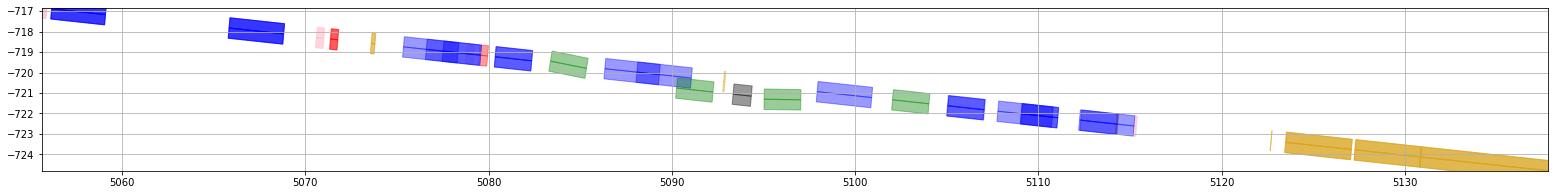

In [45]:
RotAngle = -90
plotSize = 3
scale = 9

#Filenames
file0 = r"CorrectBeatch/h2-2021a-Current.out"
#file2 = r"CorrectBeatch/H2-VLE-BEATCH_v6.1.out"
#file2 = r"CorrectBeatch/NewH2_BEATCH_v2.1.out"
#file2 = r"CorrectBeatch/NewH2_BEATCH_v3.1.out"
#file2 = r"CorrectBeatch/NewH2_BEATCH_v8.3.out"
#file1 = r"CorrectBeatch/H2-VLE-Budget-BEATCH_v0_1.out"
#file2 = r"CorrectBeatch/H2-2023-Budget-BEATCH_v0_1.out"

file1 = r"FinalBeatches/H2-VLE-Budget-BEATCH_v2_1.out"
file2 = r"FinalBeatches/H2-2023-Budget-BEATCH_v2_1.out"

    
    
    
#Orients plot the right way
if RotAngle == 0 or RotAngle == 180:
    plt.rcParams["figure.figsize"] = (plotSize, plotSize * scale)
elif RotAngle == 90 or RotAngle == -90 or RotAngle == 270:
    plt.rcParams["figure.figsize"] = (plotSize * scale, plotSize)
else:
    plt.rcParams["figure.figsize"] = (15,15)
    
#Read beatch files, adds offset if necessary
fileElements0 = ReadBeatchOut(file0)

fileElements1 = ReadBeatchOut(file1, offsetX = 0)
fileElements2 = ReadBeatchOut(file2, offsetX = 0)



#Concatenate the 2 lines so both are plotted at the same time. Pick the start and end of the list so that we can focus on the parts that we are interested in
fileElements = []
fileElements +=  fileElements0[170:-50] 
fileElements +=  fileElements1[170:-50] 
fileElements +=  fileElements2[170:-50]



ax = PlotLine(fileElements, RotAngle = RotAngle)
plt.show()

Current H2 configuration


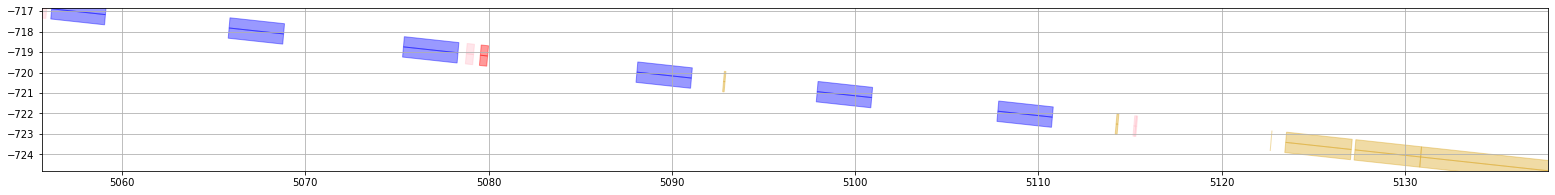

H2-Low Energy configuration


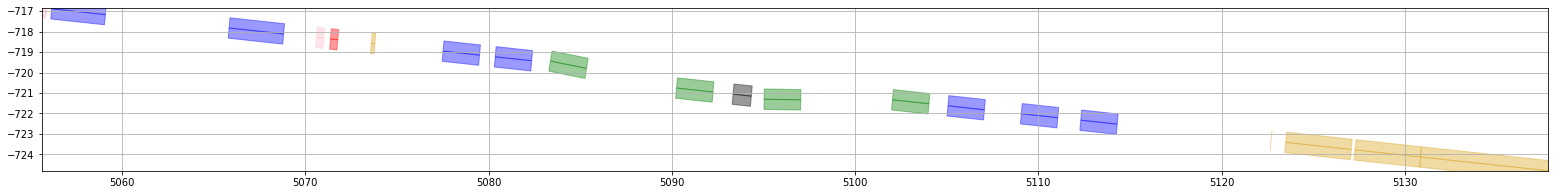

H2-2023 configuration


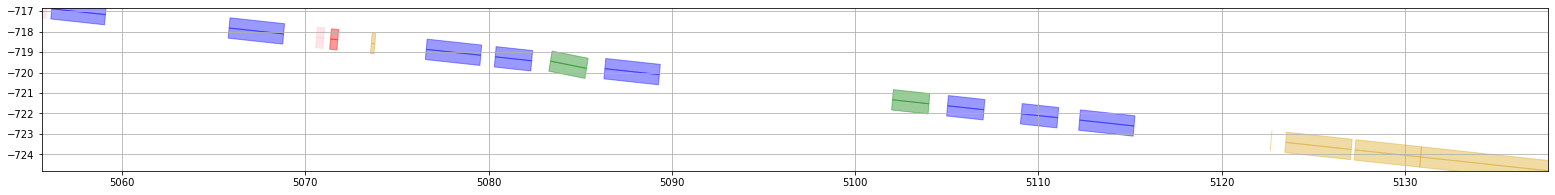

In [48]:
## fileElements =  fileElements0[170:-50] #+ fileElements1[170:-50] + fileElements2[170:-50]

ax = PlotLine(fileElements0[170:-50], RotAngle = RotAngle)
#print("\n\n")
print("Current H2 configuration")
plt.show()
    
fileElements =   fileElements1[170:-50] #+ fileElements2[170:-50]

ax = PlotLine(fileElements, RotAngle = RotAngle)
#print("\n\n")
print("H2-Low Energy configuration")
plt.show()

fileElements =  fileElements2[170:-50] + [fileElements1[194]] + [fileElements1[208]]

ax = PlotLine(fileElements, RotAngle = RotAngle)


#print("\n\n")
print("H2-2023 configuration")
plt.show()

In [42]:
fileElements1[208].elemName

'MBPL021516'

In [17]:
original = fileElements0
compare  = fileElements1

tracker = 0
SofCompared    = compare[tracker].elemS

t = PrettyTable(['Name 1', 'Name 2', 'X1', 'X2', 'Diff X',  'Y1', 'Y2', 'Diff Y', 'Z1', 'Z2', 'Diff Z', 'S1', 'S2', 'Diff S'])



nameofCompared = compare[tracker].elemName
SofCompared    = compare[tracker].elemS
XofCompared    = compare[tracker].elemX
YofCompared    = compare[tracker].elemY
ZofCompared    = compare[tracker].elemZ

for i, elem in enumerate(original[1:]):
    
    FirstPass = True
    SofNEXTOGElement = elem.elemS
    
    nameofOGElement = original[i].elemName
    SofOGElement    = original[i].elemS
    XofOGElement    = original[i].elemX
    YofOGElement    = original[i].elemY
    ZofOGElement    = original[i].elemZ
    
    


    SofComparedtxt    = SofCompared
    #print("In loop:", SofNEXTOGElement, SofOGElement, SofComparedtxt)

    while SofCompared < SofNEXTOGElement:
        

        
        #print('looping',SofCompared )
        
        if FirstPass:
            t.add_row([nameofOGElement, nameofCompared, 
                       XofOGElement, XofCompared, round(XofOGElement - XofCompared, 5),
                       YofOGElement, YofCompared, round(YofOGElement - YofCompared, 5),
                       ZofOGElement, ZofCompared, round(ZofOGElement - ZofCompared, 5), 
                       SofOGElement, SofCompared, round(SofOGElement - SofCompared, 5) ])
            tracker += 1
            FirstPass = False
        
        else:
        
            t.add_row(['"', nameofCompared,
                       '"', XofCompared, round(XofOGElement - XofCompared, 5),
                       '"', YofCompared, round(YofOGElement - YofCompared, 5), 
                       '"', ZofCompared, round(ZofOGElement - ZofCompared, 5), 
                       '"', SofCompared, round(SofOGElement - SofCompared, 5) ])
            tracker +=1
        
        if tracker < len(compare):
            nameofCompared = compare[tracker].elemName
            SofCompared    = compare[tracker].elemS
            XofCompared    = compare[tracker].elemX
            YofCompared    = compare[tracker].elemY
            ZofCompared    = compare[tracker].elemZ
            
        else:break

    
        
print(t)

+------------+------------+-----------+-----------+----------+------------+------------+----------+----------+----------+--------+---------+---------+--------+
|   Name 1   |   Name 2   |     X1    |     X2    |  Diff X  |     Y1     |     Y2     |  Diff Y  |    Z1    |    Z2    | Diff Z |    S1   |    S2   | Diff S |
+------------+------------+-----------+-----------+----------+------------+------------+----------+----------+----------+--------+---------+---------+--------+
| T2  CENTRE | T2  CENTRE | 669.23414 | 669.23414 |   0.0    | 4590.7279  | 4590.7279  |   0.0    | 2441.574 | 2441.574 |  0.0   |   0.0   |   0.0   |  0.0   |
| BEGIN VAC  |            | 669.36217 | 669.36217 |   0.0    | 4591.82143 | 4591.82143 |   0.0    | 2441.574 | 2441.574 |  0.0   |  1.101  |  1.101  |  0.0   |
|     "      | BEGIN VAC  |     "     | 669.36217 |   0.0    |     "      | 4591.82143 |   0.0    |    "     | 2441.574 |  0.0   |    "    |  1.101  |  0.0   |
|            |            | 669.39113 | 

In [18]:
original = fileElements2
compare  = fileElements0

tracker = 0
SofCompared    = compare[tracker].elemS

t = PrettyTable(['Name 1', 'Name 2', 'X1', 'X2', 'Diff X',  'Y1', 'Y2', 'Diff Y', 'Z1', 'Z2', 'Diff Z', 'S1', 'S2', 'Diff S'])


namesOriginal = [e.elemName for e in original if e.elemName != '          ']
namesCompare  = [e.elemName for e in compare  if e.elemName != '          ']


nameofCompared = compare[tracker].elemName
SofCompared    = compare[tracker].elemS
XofCompared    = compare[tracker].elemX
YofCompared    = compare[tracker].elemY
ZofCompared    = compare[tracker].elemZ

for i, elem in enumerate(original[1:]):
    
    FirstPass = True
    SofNEXTOGElement = elem.elemS
    
    nameofOGElement = original[i].elemName
    SofOGElement    = original[i].elemS
    XofOGElement    = original[i].elemX
    YofOGElement    = original[i].elemY
    ZofOGElement    = original[i].elemZ
    
    


    SofComparedtxt    = SofCompared
    #print("In loop:", SofNEXTOGElement, SofOGElement, SofComparedtxt)

    while SofCompared < SofNEXTOGElement:
        

        
        #print('looping',SofCompared )
        
        if FirstPass:
            t.add_row([nameofOGElement, nameofCompared, 
                       XofOGElement, XofCompared, round(XofOGElement - XofCompared, 5),
                       YofOGElement, YofCompared, round(YofOGElement - YofCompared, 5),
                       ZofOGElement, ZofCompared, round(ZofOGElement - ZofCompared, 5), 
                       SofOGElement, SofCompared, round(SofOGElement - SofCompared, 5) ])
            tracker += 1
            FirstPass = False
        
        else:
        
            t.add_row(['"', nameofCompared,
                       '"', XofCompared, round(XofOGElement - XofCompared, 5),
                       '"', YofCompared, round(YofOGElement - YofCompared, 5), 
                       '"', ZofCompared, round(ZofOGElement - ZofCompared, 5), 
                       '"', SofCompared, round(SofOGElement - SofCompared, 5) ])
            tracker +=1
        
        if tracker < len(compare):
            nameofCompared = compare[tracker].elemName
            SofCompared    = compare[tracker].elemS
            XofCompared    = compare[tracker].elemX
            YofCompared    = compare[tracker].elemY
            ZofCompared    = compare[tracker].elemZ
            
        else:break

    
        
print(t)

+------------+------------+-----------+-----------+----------+------------+------------+----------+----------+----------+--------+---------+---------+--------+
|   Name 1   |   Name 2   |     X1    |     X2    |  Diff X  |     Y1     |     Y2     |  Diff Y  |    Z1    |    Z2    | Diff Z |    S1   |    S2   | Diff S |
+------------+------------+-----------+-----------+----------+------------+------------+----------+----------+----------+--------+---------+---------+--------+
| T2  CENTRE | T2  CENTRE | 669.23414 | 669.23414 |   0.0    | 4590.7279  | 4590.7279  |   0.0    | 2441.574 | 2441.574 |  0.0   |   0.0   |   0.0   |  0.0   |
| BEGIN VAC  |            | 669.36217 | 669.36217 |   0.0    | 4591.82143 | 4591.82143 |   0.0    | 2441.574 | 2441.574 |  0.0   |  1.101  |  1.101  |  0.0   |
|     "      | BEGIN VAC  |     "     | 669.36217 |   0.0    |     "      | 4591.82143 |   0.0    |    "     | 2441.574 |  0.0   |    "    |  1.101  |  0.0   |
|            |            | 669.39113 | 

In [19]:
original = fileElements2
compare  = fileElements1

tracker = 0
SofCompared    = compare[tracker].elemS

t = PrettyTable(['Name 1', 'Name 2', 'X1', 'X2', 'Diff X',  'Y1', 'Y2', 'Diff Y', 'Z1', 'Z2', 'Diff Z', 'S1', 'S2', 'Diff S'])


namesOriginal = [e.elemName for e in original if e.elemName != '          ']
namesCompare  = [e.elemName for e in compare  if e.elemName != '          ']


nameofCompared = compare[tracker].elemName
SofCompared    = compare[tracker].elemS
XofCompared    = compare[tracker].elemX
YofCompared    = compare[tracker].elemY
ZofCompared    = compare[tracker].elemZ

for i, elem in enumerate(original[1:]):
    
    FirstPass = True
    SofNEXTOGElement = elem.elemS
    
    nameofOGElement = original[i].elemName
    SofOGElement    = original[i].elemS
    XofOGElement    = original[i].elemX
    YofOGElement    = original[i].elemY
    ZofOGElement    = original[i].elemZ
    
    


    SofComparedtxt    = SofCompared
    #print("In loop:", SofNEXTOGElement, SofOGElement, SofComparedtxt)

    while SofCompared < SofNEXTOGElement:
        

        
        #print('looping',SofCompared )
        
        if FirstPass:
            t.add_row([nameofOGElement, nameofCompared, 
                       XofOGElement, XofCompared, round(XofOGElement - XofCompared, 5),
                       YofOGElement, YofCompared, round(YofOGElement - YofCompared, 5),
                       ZofOGElement, ZofCompared, round(ZofOGElement - ZofCompared, 5), 
                       SofOGElement, SofCompared, round(SofOGElement - SofCompared, 5) ])
            tracker += 1
            FirstPass = False
        
        else:
        
            t.add_row(['"', nameofCompared,
                       '"', XofCompared, round(XofOGElement - XofCompared, 5),
                       '"', YofCompared, round(YofOGElement - YofCompared, 5), 
                       '"', ZofCompared, round(ZofOGElement - ZofCompared, 5), 
                       '"', SofCompared, round(SofOGElement - SofCompared, 5) ])
            tracker +=1
        
        if tracker < len(compare):
            nameofCompared = compare[tracker].elemName
            SofCompared    = compare[tracker].elemS
            XofCompared    = compare[tracker].elemX
            YofCompared    = compare[tracker].elemY
            ZofCompared    = compare[tracker].elemZ
            
        else:break

    
        
print(t)

+------------+------------+-----------+-----------+----------+------------+------------+----------+----------+----------+--------+---------+---------+--------+
|   Name 1   |   Name 2   |     X1    |     X2    |  Diff X  |     Y1     |     Y2     |  Diff Y  |    Z1    |    Z2    | Diff Z |    S1   |    S2   | Diff S |
+------------+------------+-----------+-----------+----------+------------+------------+----------+----------+----------+--------+---------+---------+--------+
| T2  CENTRE | T2  CENTRE | 669.23414 | 669.23414 |   0.0    | 4590.7279  | 4590.7279  |   0.0    | 2441.574 | 2441.574 |  0.0   |   0.0   |   0.0   |  0.0   |
| BEGIN VAC  |            | 669.36217 | 669.36217 |   0.0    | 4591.82143 | 4591.82143 |   0.0    | 2441.574 | 2441.574 |  0.0   |  1.101  |  1.101  |  0.0   |
|     "      | BEGIN VAC  |     "     | 669.36217 |   0.0    |     "      | 4591.82143 |   0.0    |    "     | 2441.574 |  0.0   |    "    |  1.101  |  0.0   |
|            |            | 669.39113 | 